# Tutorial: Digit classification using convolutional networks

In this notebook we will get familiar with the basics of Keras by trying to classify images of handwritten digits, which is known as the MNIST dataset. The images contain single digits (so numbers 0 to 9), meaning we have to do multiclass classification. 

This is a relatively simple task for us to do today, but was among the coolest problems you could work on in 1998. We will try out two different models -- first a plain feed-forward neural network, then one based on convolutions. 

This notebook is based on one of the Keras examples: https://keras.io/examples/vision/mnist_convnet/ Here you will find a lot on interesting examples of computer vision models -- many of them rather advanced. This one is, however, a nice starting point.

## Setup
Import the libraries we need.

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt

2026-01-11 11:19:10.221821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768126750.382342   42994 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768126750.426091   42994 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-11 11:19:11.020165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and prepare the data


In [2]:
# Ten classes (numbers 0 to 9)
num_classes = 10

# The images are 28x28 pixels, and have one channel (grayscale). 
# For color images, the last number here would be 3 (red/green/blue channel).
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Look at some of the data.

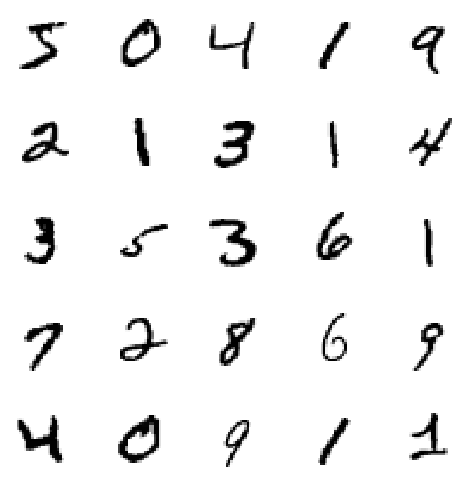

In [3]:
n_rows = 5
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

## Model number 1: A simple feed-forward network

This "multi-layer perceptron" tries to recognise patterns based on the value of each individual pixel, at its fixed position in the image.

First, we define the model and print it:

In [4]:
ff_network = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

ff_network.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
W0000 00:00:1768126759.611351   42994 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Notice that we used the _sequential model API_: We made a list of layers and gave it as input to [`keras.Sequential`](https://keras.io/guides/sequential_model/). This is the most convenient way to create a model where each layer connects directly to the next. In case we need a more advanced layout of the model, we will have to use the _functional model API_, which we will look at later.

Next, we need to specify the loss function, the optimisation algorithm to use, and any metrics we want to measure during training. Since the classes (0-9) are evenly distributed, we choose to measure the accuracy.
"Compiling" the model configures it according to the given specification.

In [5]:
ff_network.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Now we are ready to train the model:

In [6]:
batch_size = 128    # How many images to load in a single batch
epochs = 10         # How many times to iterate over the full dataset

ff_network.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7335 - loss: 0.9108 - val_accuracy: 0.9383 - val_loss: 0.2197
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9252 - loss: 0.2577 - val_accuracy: 0.9547 - val_loss: 0.1639
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9441 - loss: 0.1958 - val_accuracy: 0.9605 - val_loss: 0.1423
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9552 - loss: 0.1578 - val_accuracy: 0.9630 - val_loss: 0.1317
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9587 - loss: 0.1410 - val_accuracy: 0.9630 - val_loss: 0.1237
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9652 - loss: 0.1211 - val_accuracy: 0.9658 - val_loss: 0.1230
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9650 - loss: 0.1160 - val_accuracy: 0.9660 - val_loss: 0.1137
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9698 - loss: 0.1050 - val_accuracy: 0.

Let's evaluate the network on the test data:

In [7]:
score = ff_network.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.11876217275857925
Test accuracy: 0.9641000032424927


## A better network: The convolutional neural network (_convnet_)

Now let's construct a model based on convolutional and pooling layers.

In [8]:
convnet = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

convnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,578 (68.66 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train it on the same data as before:

In [9]:
convnet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

convnet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7209 - loss: 0.8898 - val_accuracy: 0.9758 - val_loss: 0.0924
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9577 - loss: 0.1411 - val_accuracy: 0.9825 - val_loss: 0.0658
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9691 - loss: 0.1026 - val_accuracy: 0.9870 - val_loss: 0.0498
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9737 - loss: 0.0871 - val_accuracy: 0.9868 - val_loss: 0.0472
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9768 - loss: 0.0758 - val_accuracy: 0.9890 - val_loss: 0.0424
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9794 - loss: 0.0675 - val_accuracy: 0.9897 - val_loss: 0.0402
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9827 - loss: 0.0566 - val_accuracy: 0.9905 - val_loss: 0.0369
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9820 - loss: 0.0580 - val_accuracy: 0.

And evaluate the results:

In [10]:
score = convnet.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03183649480342865
Test accuracy: 0.9891999959945679


Notice how we made a smaller model (17k vs 26k number of parameters), but still got better results.